![](cat.jpg)

# Pose Determination

Kevin J. Walchko, Phd

18 Feb 2021

---

![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7b/Angle_axis_vector.svg/300px-Angle_axis_vector.svg.png)
*Note:* changed $\theta$ to r since the bold face didn't show up nicely in latex.

Rodrigues' rotation formula, named after Olinde Rodrigues, is an efficient algorithm for rotating for an axis-angle ($r$) representation consisting of a vector in space, given an axis ($e$) and angle of rotation ($\theta$). By extension, this can be used to transform all three basis vectors to compute a rotation matrix in SO(3), the group of all rotation matrices, from an axis–angle representation. 

$$
r = \begin{bmatrix} r_x & r_y & r_z \end{bmatrix} = \theta e\\
\theta = norm( r ) \\
e = r / \theta \\
R = I + (sin \theta) K + (1-cos \theta) K^2 \\
K = skew(r) = \begin{bmatrix}
    0 & -r_z & r_y \\
    r_z & 0 & -r_x \\
    -r_y & r_x & 0
\end{bmatrix}
$$

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from numpy.linalg import norm
from math import atan2, asin, pi, sin, cos

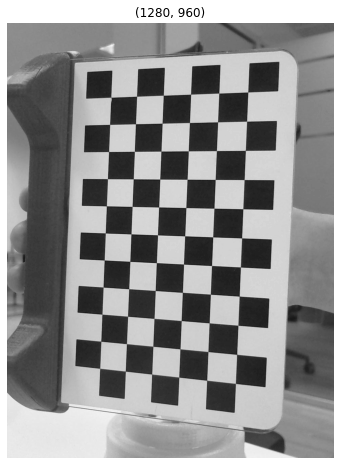

In [3]:
img = cv2.imread("frame0.jpg", 0)

plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray")
plt.title(f"{img.shape}")
plt.axis('off');

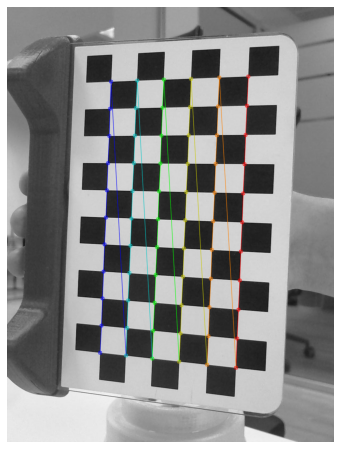

In [29]:
# Pattern parameters
rows = 6
columns = 11
square_width = 13

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(
    img, 
    (columns, rows), 
    flags=cv2.CALIB_CB_FAST_CHECK
)

# Draw corners into image
image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.drawChessboardCorners(image, (columns, rows), corners, ret)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(image, cmap="gray")
plt.axis('off');

In [36]:
# Compute object points
# these are the ideal points in a 2D plane if we were looking
# straight down on the checkerboard
objp = np.zeros((rows * columns, 3), float)
objp[:, :2] = np.mgrid[0:columns, 0:rows].T.reshape(-1, 2)
objp *= square_width

# Camera calibration results
f = 1430       # focal length
p = (640,480,) # principle point
p = (480,640,) # principle point
camera_matrix = np.array([
    [f, 0, p[0]],
    [0, f, p[1]],
    [0, 0,   1]], dtype=float)
distortion_coefficients = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float)

# Compute pose
ret, rvecs, tvecs = cv2.solvePnP(
    objp, 
    corners, 
    camera_matrix, 
    distortion_coefficients)

if ret:
    print(f"rvecs:\n{rvecs}\n")
    print(f"tvecs:\n{tvecs}\n")
    
    R = cv2.Rodrigues(rvecs)[0]
    t = tvecs.T[0]
    n = R.T[2]
    d = np.dot(n, t)
    print(f"\nRotation matrix\n\n{R}\n")
    print(f"\nTranslation vector\n\n{t} mm\n")
    print(f"\nPlane normal\n\n{n}\n")
    print(f"\nPlane distance\n\n{d} mm\n")

rvecs:
[[0.12570041]
 [0.16640763]
 [1.59871551]]

tvecs:
[[  9.57346786]
 [-41.26227895]
 [220.41267266]]


Rotation matrix

[[-0.03512156 -0.9823659   0.18364017]
 [ 0.99912725 -0.03035743  0.02869093]
 [-0.02261015  0.18448757  0.98257474]]


Translation vector

[  9.57346786 -41.26227895 220.41267266] mm


Plane normal

[0.18364017 0.02869093 0.98257474]


Plane distance

217.1461445363624 mm



## Calculating Euler Angles

Euler angles are non-unique definitions of the orientation of a body (typically something like an airplane) relative to a fixed set of *global* (non-moving) axes. The definitions for roll, pitch, and yaw are shown below.

![](pyr.png)

The goal here is to calculate roll, pitch, and yaw and then draw it on the image for reference.

![](pattern_pose.png)

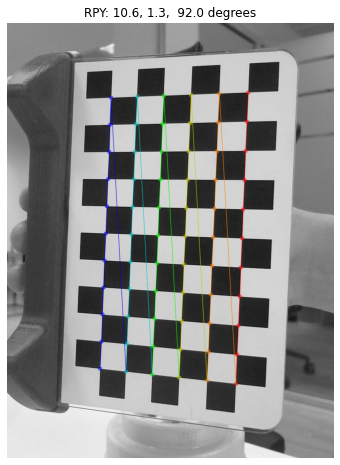

In [30]:
# R321
roll = atan2(R[2,1], R[2,2])*180/pi
pitch = -asin(R[2,0])*180/pi
yaw = atan2(R[1,0], R[0,0])*180/pi

plt.figure(figsize=(8,8))
plt.imshow(image, cmap="gray")
plt.title(f"RPY: {roll:0.1f}, {pitch:0.1f}, {yaw: 0.1f} degrees")
plt.axis('off');

In [17]:
def draw(image, corners, imgpts, thick=5):
    img = image.copy()
    corner = tuple(corners[0].ravel())
    img = cv2.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), thick)
    img = cv2.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), thick)
    img = cv2.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), thick)
    return img

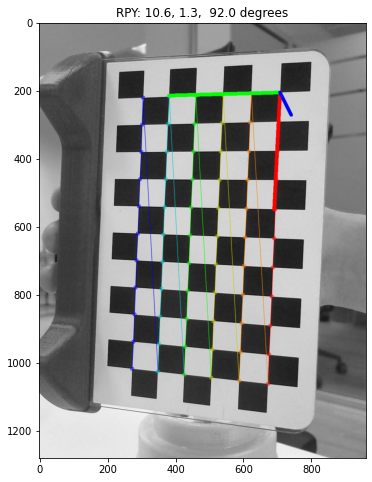

In [40]:
# set the axes size as a function of the marker's 
# square size and project onto image space
s = 4*square_width
axis = np.array([[s,0,0], [0,s,0], [0,0,s]], dtype=float).reshape(-1,3)

imgpts, jac = cv2.projectPoints(
    axis, 
    rvecs, 
    tvecs, 
    camera_matrix, 
    distortion_coefficients
)

aimg = draw(image,corners.astype(int),imgpts.astype(int),10)

# The x and y axes should lie on the surface of the image
# while the x axis is into the chessboard
plt.figure(figsize=(8,8))
# plt.title("Axes X-Y-Z => R-G-B")
plt.title(f"RPY: {roll:0.1f}, {pitch:0.1f}, {yaw: 0.1f} degrees")
plt.imshow(aimg);

In [45]:
# o = tuple(corners[0].ravel())
# x = imgpts[0].ravel() - o
# y = imgpts[1].ravel() - o
# z = imgpts[2].ravel() - o
# print(x,y,z)

# print(R @ axis.T)
# print(imgpts)

[-17.08717661 345.59359371] [-325.69330557    9.50005818] [33.09889985 66.38473299]
[[ -1.82632108 -51.08302684   9.54928901]
 [ 51.95461689  -1.57858614   1.49192822]
 [ -1.17572758   9.59335369  51.09388642]]
[[[690.53171987 549.74209224]]

 [[381.92559091 213.64855671]]

 [[740.71779634 270.53323153]]]


# References

- github: [3D Scan Science](https://github.com/Jesus89/3DScanScience)
- OpenCV Docs [pose](https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html)
- OpenCV Docs [solvePnP](https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga549c2075fac14829ff4a58bc931c033d)
- wikipedia: [Rodriques rotations](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula)
- wikipedia: [axis angle representation](https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation)

# Appedix: Rodrigues to Rotation Matrix

The equation from above again is:

$$
R = I + (sin \theta) K + (1-cos \theta) K^2
$$

This should be the same as `cv2.Rodrigues(rvecs)`.

In [24]:
print(f"rvecs:\n {rvecs}\n\n")

def skew(x):
    return np.array([
        [0.0, -x[2], x[1]],
        [x[2], 0.0, -x[0]],
        [-x[1], x[0], 0.0]
    ])

rr, _ = cv2.Rodrigues(rvecs)
print("cv2.Rodrigues:\n", rr, "\n\n")

r = rvecs.ravel()
theta = norm(r)
e = r/t
k = skew(e)
rot = np.eye(3) + sin(theta) * k + (1-cos(theta)) * k@k
print("wikipedia:\n", rot)

rvecs:
 [[0.12570041]
 [0.16640763]
 [1.59871551]]


cv2.Rodrigues:
 [[-0.03512156 -0.9823659   0.18364017]
 [ 0.99912725 -0.03035743  0.02869093]
 [-0.02261015  0.18448757  0.98257474]] 


wikipedia:
 [[ 0.99992827 -0.0073022  -0.00393027]
 [ 0.0071919   0.99976566 -0.01314926]
 [ 0.00412864  0.01308833  0.99980352]]
